In [1]:
from keras.layers import Input,Dense,Concatenate
from keras.models import Model
import pandas as pd
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
from sklearn.preprocessing import MinMaxScaler

def build_generator(input_size):
    """Builds and compiles the generator model.

    Args:
        input_size (int): The number of input features.

    Returns:
        A compiled Keras model object.
    """
    # Define input layers
    input_missing = Input(shape=(input_size,))
    input_hints = Input(shape=(input_size,))

    # Define hidden layers
    x = Concatenate()([input_missing, input_hints])
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    output_imputed = Dense(input_size, activation='tanh')(x)

    # Define generator model
    generator = Model(inputs=[input_missing, input_hints], outputs=output_imputed)

    # Compile generator model
    generator.compile(loss='binary_crossentropy', optimizer='adam')

    return generator


def build_discriminator(input_size):
    """Builds and compiles the discriminator model.

    Args:
        input_size (int): The number of input features.

    Returns:
        A compiled Keras model object.
    """
    # Define input layer
    input_data = Input(shape=(input_size,))

    # Define hidden layers
    x = Dense(256, activation='relu')(input_data)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    output_prob = Dense(1, activation='sigmoid')(x)

    # Define discriminator model
    discriminator = Model(inputs=input_data, outputs=output_prob)

    # Compile discriminator model
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    return discriminator


2023-04-07 15:36:07.027239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 15:36:08.427740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 15:36:08.427851: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-07 15:36:11.994501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
from keras.losses import mse as mse_loss, binary_crossentropy as bce_loss

def gain_impute(data, hint_probability=0.9, batch_size=64, epochs=10000):
    # Convert input data to NumPy array
    tmp = data.columns
    data = data.values.astype('float32')

    # Create mask of missing values
    mask = np.isnan(data)
    # mask = data.isna().to_numpy()

    # Create generator and discriminator models
    generator = build_generator(data.shape[1])
    discriminator = build_discriminator(data.shape[1])

    # Compile discriminator model
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    # Create scaler object for data scaling and unscaling
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data)

    # Scale data to range [-1, 1]
    data_scaled = scaler.transform(data)

    # Train generator and discriminator models
    for epoch in range(epochs):
        # Create batches of observed and missing data
        indices = np.arange(data.shape[0])
        np.random.shuffle(indices)
        for i in range(0, data.shape[0], batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_missing = data_scaled[batch_indices] * mask[batch_indices]
            batch_observed = data_scaled[batch_indices] * (1 - mask[batch_indices])
            batch_hints = None
            batch_hints = (np.random.random(batch_missing.shape) < hint_probability).astype('float32')
            batch_hints = tf.cast(batch_hints, tf.float32)
            # print(batch_hints.dtype)
            
            # Generate fake data using generator model
            #print('-----------',batch_missing,'========',batch_hints)
            fake_data = generator.predict([batch_missing, batch_hints])
            data_hints = batch_missing * (1 - batch_hints) + fake_data * batch_hints
            
            # Train discriminator model
            discriminator.train_on_batch(batch_observed, np.ones((len(batch_observed), 1)))
            discriminator.train_on_batch(fake_data, np.zeros((len(fake_data), 1)))
            discriminator.train_on_batch(data_hints, batch_hints)

            # Train generator model
            gen_loss = 0.5 * mse_loss(batch_hints * fake_data,batch_hints * data_scaled[batch_indices]) + \
                       0.5 * mse_loss((1 - batch_hints) * fake_data, (1 - batch_hints) * batch_observed) + \
                       0.5 * bce_loss(discriminator(data_hints), tf.cast(batch_hints, dtype='float32'))
            generator.train_on_batch([batch_missing, batch_hints], batch_observed)
            
            # Test the generator model by generating some data
            test_missing = np.zeros((10, data.shape[1]), dtype='float32')
            test_hints = np.ones((10, data.shape[1]), dtype='float32')
            test_data = generator.predict([test_missing, test_hints])
            #print(test_data)
            
    # Generate imputed data using generator model
    imputed_data = generator.predict([data_scaled * mask, np.ones_like(data_scaled)])
    #print([data_scaled * mask])
    #print(imputed_data)
    # Unscale imputed data to original range
    imputed_data = scaler.inverse_transform(imputed_data)

    # Fill in missing values with imputed data
    data_filled = data.copy()
    data_filled[mask] = imputed_data[mask]
    data_filled = np.nan_to_num(data_filled, nan=data_filled.mean())
    data[mask] = imputed_data[mask]
    data = np.nan_to_num(data, nan=data.mean())

    # Convert imputed data to pandas DataFrame
    imputed_df = pd.DataFrame(data_filled, columns=tmp)
    
    # Assuming 'generator' is the generator model object
    generator_weights = generator.get_weights()
    #rint('------------------',generator_weights)

    return imputed_df,generator


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [5]:
data = load_iris()
df = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + ['target'])

In [6]:
def randomly_missing(data, n_sample):
    h, w = data.shape[0], data.shape[1] 
    n = data.shape[0]*data.shape[1] 
    # print(h,w,n)
    perc = n_sample / n 
    flattenX = data.to_numpy().reshape(1, n)
    mask = np.random.uniform(0,1, size = n) < perc
    flattenX[:, mask] = np.nan 
    return pd.DataFrame(data=flattenX.reshape(h, w),columns=data.columns) 

In [7]:
# new_df = apply_random_missing_for_all(data1,10)
new_df = randomly_missing(df,n_sample=10)

In [9]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
def apply_normalize(df):
    output = df.copy()
    # scaler = MinMaxScaler() #StandardNormalize -> 
    scaler = StandardScaler()
    for each in output.columns:
      output[each] = scaler.fit_transform(output[[each]])
    return output

In [10]:
n_df = apply_normalize(new_df)

<AxesSubplot: >

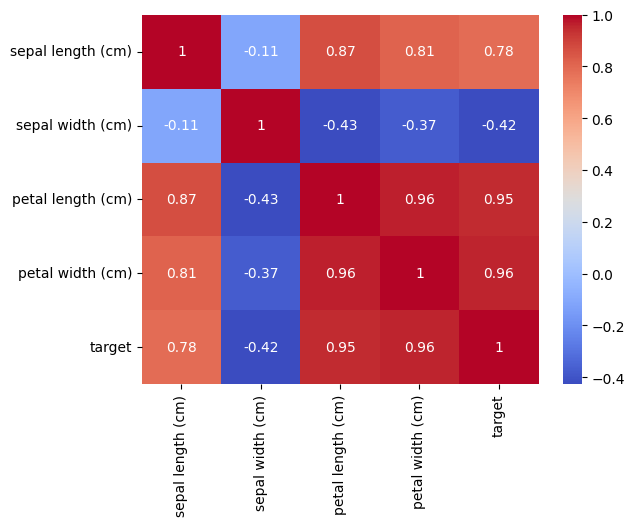

In [11]:
import seaborn as sns
import pandas as pd

corr_matrix = n_df.corr() # grouth truth
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)


In [12]:
imputed_data, model = gain_impute(n_df, hint_probability=0.1, batch_size=128,epochs=20)

2023-04-07 15:40:01.919652: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-07 15:40:01.919696: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-07 15:40:01.919731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hp): /proc/driver/nvidia/version does not exist
2023-04-07 15:40:01.920251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 0s 7ms/step


<AxesSubplot: >

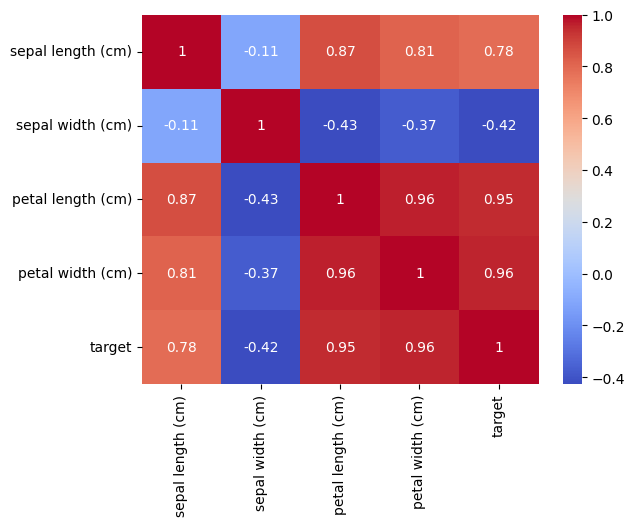

In [14]:
import seaborn as sns
import pandas as pd

corr_matrix_gain = imputed_data.corr() # grouth truth
sns.heatmap(corr_matrix_gain, cmap='coolwarm', annot=True)

In [15]:
def covariance_rmse(cov_matrix1, cov_matrix2):
    # Convert covariance matrices to correlation matrices
    std1 = np.sqrt(np.diag(cov_matrix1))
    corr_matrix1 = cov_matrix1 / np.outer(std1, std1)

    std2 = np.sqrt(np.diag(cov_matrix2))
    corr_matrix2 = cov_matrix2 / np.outer(std2, std2)

    # Calculate the difference between the two correlation matrices
    diff = corr_matrix1 - corr_matrix2

    # Square each element in the difference matrix
    squared_diff = np.square(diff)

    # Take the mean of the squared differences
    mean_squared_diff = np.mean(squared_diff)

    # Take the square root of the mean squared difference to get the RMSE
    rmse = np.sqrt(mean_squared_diff)

    # Check if any elements in rmse are NaN
    nan_mask = np.isnan(rmse)
    if np.any(nan_mask):
        # Remove NaN elements from rmse and print a message
        nan_indices = np.where(nan_mask)[0]
        print(f"Elements {nan_indices} are NaN and will be removed.")
        rmse = rmse[~nan_mask]

    total_rmse = (1/len(rmse)) * sum(rmse) 
    print("Total : ",total_rmse)
    return rmse

In [16]:
corr_matrix_gt = df.corr()
covariance_rmse(corr_matrix_gt, corr_matrix_gain)

Total :  2.7937055395561207e-09


/home/pn7hao/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


sepal length (cm)    1.707046e-09
sepal width (cm)     4.219008e-09
petal length (cm)    1.930111e-09
petal width (cm)     1.314958e-09
target               4.797405e-09
dtype: float64